In [1]:
import os, sys, time, datetime, json, random
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from tensorflow.keras.optimizers import SGD , Adam, RMSprop
from keras.layers.advanced_activations import PReLU
from keras.layers.advanced_activations import LeakyReLU
from keras.activations import relu
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [2]:
visited_mark = 0.9
book_mark = 0.65
robot_mark = 0.5

actions_dict = {
    0: 'left',
    1: 'up',
    2: 'right',
    3: 'down',
}

num_actions = len(actions_dict)

In [3]:
class Environment(object):
    def __init__(self, map, books, robot=(0,0), target=None):
        self._map = np.array(map)
        self._books = set(books)
        nrows, ncols = self._map.shape
        if target is None:
            self.target = (nrows-1, ncols-1)   # default target cell where the robot to deliver the "books"
        self.free_cells = set((r,c) for r in range(nrows) for c in range(ncols) if self._map[r,c] == 1.0)
        self.free_cells.discard(self.target)
        self.free_cells -= self._books
        if self._map[self.target] == 0.0:
            raise Exception("Invalid map: target cell cannot be blocked!")
        if not robot in self.free_cells:
            raise Exception("Invalid robot Location: must sit on a free cell")
        self.reset(robot)

    def reset(self, robot=(0,0)):
        self.robot = robot
        self.map = np.copy(self._map)
        self.books = set(self._books)
        nrows, ncols = self.map.shape
        row, col = robot
        self.map[row, col] = robot_mark
        self.state = ((row, col), 'start')
        self.base = np.sqrt(self.map.size)
        self.visited = dict(((r,c),0) for r in range(nrows) for c in range(ncols) if self._map[r,c] == 1.0)
        self.total_reward = 0
        self.min_reward = -0.5 * self.map.size
        self.reward = {
            'blocked':  self.min_reward,
            'book':     1.0/len(self._books),
            'invalid': -4.0/self.base,
            'valid':   -1.0/self.map.size
        }

    def step(self, action):
        self.update_state(action)
        reward = self.get_reward()
        self.total_reward += reward
        status = self.game_status()
        env_state = self.observe()
        return env_state, reward, status

    def get_reward(self):
        robot, mode = self.state
        if robot == self.target:
            return 1.0 - len(self.books) / len(self._books)
        if mode == 'blocked':
            return self.reward['blocked']
        elif robot in self.books:
            return self.reward['book']
        elif mode == 'invalid':
            return self.reward['invalid']
        elif mode == 'valid':
            return self.reward['valid'] #* (1 + 0.1*self.visited[robot] ** 2)

    def update_state(self, action):
        nrows, ncols = self.map.shape
        (nrow, ncol), nmode = robot, mode = self.state

        if self.map[robot] > 0.0:
            self.visited[robot] += 1  # mark visited cell
        if robot in self.books:
            self.books.remove(robot)

        valid_actions = self.valid_actions()

        if not valid_actions:
            nmode = 'blocked'
        elif action in valid_actions:
            nmode = 'valid'
            if action == 0:
                ncol -= 1
            elif action == 1:
                nrow -= 1
            elif action == 2:
                ncol += 1
            elif action == 3:
                nrow += 1
        else:
            nmode = 'invalid'

        robot = (nrow, ncol)
        self.state = (robot, nmode)

    def game_status(self):
        if self.total_reward < self.min_reward:
            return 'lose'
        robot, mode = self.state
        if robot == self.target:
            if len(self.books) == 0:
                return 'win'
            else:
                return 'lose'

        return 'ongoing'

    def observe(self):
        canvas = self.draw_env()
        env_state = canvas.reshape((1, -1))
        return env_state

    def draw_env(self):
        canvas = np.copy(self.map)
        nrows, ncols = self.map.shape

        for r in range(nrows):
            for c in range(ncols):
                if canvas[r,c] > 0.0:
                    canvas[r,c] = 1.0

        for r,c in self.books:
            canvas[r,c] = book_mark

        robot, mode = self.state
        canvas[robot] = robot_mark
        return canvas

    def valid_actions(self, cell=None):
        if cell is None:
            (row, col), mode = self.state
        else:
            row, col = cell
        actions = [0, 1, 2, 3]
        nrows, ncols = self.map.shape
        if row == 0:
            actions.remove(1)
        elif row == nrows-1:
            actions.remove(3)

        if col == 0:
            actions.remove(0)
        elif col == ncols-1:
            actions.remove(2)

        if row>0 and self.map[row-1,col] == 0.0:
            actions.remove(1)
        if row<nrows-1 and self.map[row+1,col] == 0.0:
            actions.remove(3)

        if col>0 and self.map[row,col-1] == 0.0:
            actions.remove(0)
        if col<ncols-1 and self.map[row,col+1] == 0.0:
            actions.remove(2)

        return actions

In [4]:
class Experience(object):
    def __init__(self, model, max_memory=100, discount=0.97):
        self.model = model
        self.max_memory = max_memory
        self.discount = discount
        self.memory = list()
        self.num_actions = model.output_shape[-1]

    def remember(self, step_value):
        self.memory.append(step_value)
        if len(self.memory) > self.max_memory:
            del self.memory[0]

    def predict(self, env_state):
        return self.model.predict(env_state)[0]

    def replay(self, data_size=10):
        env_size = self.memory[0][0].shape[1]
        mem_size = len(self.memory)
        data_size = min(mem_size, data_size)
        inputs = np.zeros((data_size, env_size))
        targets = np.zeros((data_size, self.num_actions))
        for i, j in enumerate(np.random.choice(range(mem_size), data_size, replace=False)):
            env_state, action, reward, next_env_state, game_over = self.memory[j]
            inputs[i] = env_state

            targets[i] = self.predict(env_state)

            Q_sa = np.max(self.predict(next_env_state))
            if game_over:
                targets[i, action] = reward
            else:
                targets[i, action] = reward + self.discount * Q_sa
        return inputs, targets

In [5]:
class Training(object):
    def __init__(self, model, env, **opt):
        self.model = model
        self.env = env
        self.n_epoch = opt.get('n_epoch', 100)
        self.max_memory = opt.get('max_memory', 4*self.env.map.size)
        self.data_size = opt.get('data_size', int(0.75*self.env.map.size))
        self.robot_cells = opt.get('robot_cells', [(0,0)])
        self.weights_file = opt.get('weights_file', "")
        self.name = opt.get('name', 'model')
        self.total_reward = list()

        self.win_count = 0

        if self.weights_file:
            print("loading weights from file: %s" % (self.weights_file,))
            self.model.load_weights(self.weights_file)

        if self.robot_cells == 'all':
            self.robot_cells = list(self.env.free_cells)

        self.experience = Experience(self.model, max_memory=self.max_memory)

        

    def train(self):
        start_time = datetime.datetime.now()
        self.seconds = 0
        self.win_count = 0
        for epoch in range(self.n_epoch):
            print("epoch : ",epoch)
            self.epoch = epoch
            self.loss = 0.0
            print(" robot_cells : ",self.robot_cells)
            
            robot = random.choice(self.robot_cells)
            
            self.env.reset(robot)

            print("start position : ",robot," | target : ",self.env.target)

            game_over = False
            self.env_state = self.env.observe()
            self.step = 0
            while not game_over:
                game_over = self.play()

            dt = datetime.datetime.now() - start_time
            self.seconds = dt.total_seconds()
            t = format_time(self.seconds)
            fmt = "Epoch: {:3d}/{:d} | Loss: {:.4f} | total_step: {:4d} | Wins: {:2d} | books: {:d} | e: {:.3f} | time: {}"
            print(fmt.format(epoch, self.n_epoch-1, self.loss, self.step, self.win_count, len(self.env.books), self.epsilon(), t))
            self.total_reward.append(self.env.total_reward)

    def play(self):
        action = self.action()
        prev_env_state = self.env_state
        self.env_state, reward, game_status = self.env.step(action)
        if game_status == 'win':
            self.win_count += 1
            game_over = True
        elif game_status == 'lose':
            game_over = True
        else:
            game_over = False

        step_value = [prev_env_state, action, reward, self.env_state, game_over]

        print("step : ",self.step+1," | action : ",action," | current position, mode : ",self.env.state," | game status : ",game_status," | total reward : ",self.env.total_reward)
        
        self.experience.remember(step_value)
        self.step += 1

        inputs, targets = self.experience.replay(data_size=self.data_size)
        epochs = int(self.env.base)
        h = self.model.fit(
            inputs,
            targets,
            epochs = epochs,
            batch_size=128,
            verbose=0,
        )
        self.loss = self.model.evaluate(inputs, targets, verbose=0)
        return game_over

    def action(self):
        valid_actions = self.env.valid_actions()
        if not valid_actions:
            action = None
        elif np.random.rand() < self.epsilon():
            action = random.choice(valid_actions)
        else:
            q = self.experience.predict(self.env_state)
            action = np.argmax(q)
        return action

    def epsilon(self):
        n = self.win_count
        max_es = 0.80
        min_es = 0.08
        if n<10:
            e = min_es + (max_es - min_es) / (1 + 0.1 * n**0.5)
        else:
            e = min_es
        return e
    

    def save(self, name=""):
        if not name:
            name = self.name
        h5file = 'model_%s.h5' % (name,)
        json_file = 'model_%s.json' % (name,)
        self.model.save_weights(h5file, overwrite=True)
        with open(json_file, "w") as outfile:
            json.dump(self.model.to_json(), outfile)
        t = format_time(self.seconds)
        print('files: %s, %s' % (h5file, json_file))
        print("n_epoch: %d, max_mem: %d, data: %d, time: %s" % (self.epoch, self.max_memory, self.data_size, t))
        

In [6]:
def build_model(env, **opt):
    loss = opt.get('loss', 'mse')
    a = opt.get('alpha', 0.24)
    model = Sequential()
    esize = env.map.size
    model.add(Dense(256, input_shape=(esize,)))
    model.add(LeakyReLU(alpha=a))
    model.add(Dense(128))
    model.add(LeakyReLU(alpha=a))
    model.add(Dense(num_actions))
    model.compile(optimizer='adam', loss='mse')
    return model

In [7]:
def format_time(seconds):
    if seconds < 400:
        s = float(seconds)
        return "%.1f seconds" % (s,)
    elif seconds < 4000:
        m = seconds / 60.0
        return "%.2f minutes" % (m,)
    else:
        h = seconds / 3600.0
        return "%.2f hours" % (h,)

In [8]:
map = np.array([
    [ 1.,  0.,  1.,  1.,  1., ],
    [ 1.,  0.,  1.,  1.,  1., ],
    [ 1.,  1.,  1.,  1.,  1., ],
    [ 1.,  1.,  1.,  0.,  1., ],
    [ 1.,  1.,  1.,  0.,  1., ]
])

books = [(0,3), (2,4), (3,0)]

env = Environment(map, books)

model = build_model(env)

qt = Training(
    model,
    env,
    n_epoch = 100,
    max_memory = 500,
    data_size = 100,
    name = 'leaky_dinamic',
    robot_cells = 'all'
)

### have load weight
# qt = Training(
#     model,
#     env,
#     n_epoch = 100,
#     max_memory = 500,
#     data_size = 100,
#     name = 'leaky_dinamic',
#     weights_file = 'model_leaky_dinamic.h5',
#     robot_cells = 'all'
# )

qt.train()

qt.save('leaky_dinamic')
print("Compute Time:", qt.seconds)


epoch :  0
 agent_cells :  [(4, 0), (3, 4), (3, 1), (0, 2), (2, 2), (1, 0), (1, 3), (4, 2), (1, 2), (0, 4), (2, 1), (3, 2), (4, 1), (0, 0), (2, 0), (1, 4), (2, 3)]
start position :  (4, 1)  | target :  (4, 4)
step :  1  | action :  0  | current position, mode :  ((4, 0), 'valid')  | game status :  ongoing  | total reward :  -0.04
step :  2  | action :  2  | current position, mode :  ((4, 1), 'valid')  | game status :  ongoing  | total reward :  -0.08
step :  3  | action :  1  | current position, mode :  ((3, 1), 'valid')  | game status :  ongoing  | total reward :  -0.12
step :  4  | action :  2  | current position, mode :  ((3, 2), 'valid')  | game status :  ongoing  | total reward :  -0.16
step :  5  | action :  2  | current position, mode :  ((3, 2), 'invalid')  | game status :  ongoing  | total reward :  -0.9600000000000001
step :  6  | action :  0  | current position, mode :  ((3, 1), 'valid')  | game status :  ongoing  | total reward :  -1.0
step :  7  | action :  0  | current po

step :  60  | action :  0  | current position, mode :  ((4, 1), 'valid')  | game status :  ongoing  | total reward :  -5.066666666666668
step :  61  | action :  2  | current position, mode :  ((4, 2), 'valid')  | game status :  ongoing  | total reward :  -5.106666666666668
step :  62  | action :  3  | current position, mode :  ((4, 2), 'invalid')  | game status :  ongoing  | total reward :  -5.906666666666668
step :  63  | action :  3  | current position, mode :  ((4, 2), 'invalid')  | game status :  ongoing  | total reward :  -6.706666666666668
step :  64  | action :  1  | current position, mode :  ((3, 2), 'valid')  | game status :  ongoing  | total reward :  -6.746666666666668
step :  65  | action :  0  | current position, mode :  ((3, 1), 'valid')  | game status :  ongoing  | total reward :  -6.786666666666668
step :  66  | action :  1  | current position, mode :  ((2, 1), 'valid')  | game status :  ongoing  | total reward :  -6.826666666666668
step :  67  | action :  1  | current 

step :  120  | action :  3  | current position, mode :  ((1, 0), 'valid')  | game status :  ongoing  | total reward :  -10.506666666666623
step :  121  | action :  3  | current position, mode :  ((2, 0), 'valid')  | game status :  ongoing  | total reward :  -10.546666666666622
step :  122  | action :  2  | current position, mode :  ((2, 1), 'valid')  | game status :  ongoing  | total reward :  -10.586666666666622
step :  123  | action :  3  | current position, mode :  ((3, 1), 'valid')  | game status :  ongoing  | total reward :  -10.62666666666662
step :  124  | action :  2  | current position, mode :  ((3, 2), 'valid')  | game status :  ongoing  | total reward :  -10.66666666666662
step :  125  | action :  0  | current position, mode :  ((3, 1), 'valid')  | game status :  ongoing  | total reward :  -10.706666666666619
step :  126  | action :  3  | current position, mode :  ((4, 1), 'valid')  | game status :  ongoing  | total reward :  -10.746666666666618
step :  127  | action :  3  |

step :  29  | action :  3  | current position, mode :  ((4, 0), 'valid')  | game status :  ongoing  | total reward :  -0.7866666666666671
step :  30  | action :  2  | current position, mode :  ((4, 1), 'valid')  | game status :  ongoing  | total reward :  -0.8266666666666671
step :  31  | action :  1  | current position, mode :  ((3, 1), 'valid')  | game status :  ongoing  | total reward :  -0.8666666666666671
step :  32  | action :  0  | current position, mode :  ((3, 0), 'valid')  | game status :  ongoing  | total reward :  -0.9066666666666672
step :  33  | action :  1  | current position, mode :  ((2, 0), 'valid')  | game status :  ongoing  | total reward :  -0.9466666666666672
step :  34  | action :  3  | current position, mode :  ((3, 0), 'valid')  | game status :  ongoing  | total reward :  -0.9866666666666672
step :  35  | action :  3  | current position, mode :  ((4, 0), 'valid')  | game status :  ongoing  | total reward :  -1.0266666666666673
step :  36  | action :  2  | curre

step :  89  | action :  2  | current position, mode :  ((3, 2), 'valid')  | game status :  ongoing  | total reward :  -3.946666666666669
step :  90  | action :  1  | current position, mode :  ((2, 2), 'valid')  | game status :  ongoing  | total reward :  -3.986666666666669
step :  91  | action :  2  | current position, mode :  ((2, 3), 'valid')  | game status :  ongoing  | total reward :  -4.026666666666669
step :  92  | action :  0  | current position, mode :  ((2, 2), 'valid')  | game status :  ongoing  | total reward :  -4.066666666666669
step :  93  | action :  1  | current position, mode :  ((1, 2), 'valid')  | game status :  ongoing  | total reward :  -4.106666666666669
step :  94  | action :  2  | current position, mode :  ((1, 3), 'valid')  | game status :  ongoing  | total reward :  -4.146666666666669
step :  95  | action :  1  | current position, mode :  ((0, 3), 'valid')  | game status :  ongoing  | total reward :  -3.8133333333333357
step :  96  | action :  0  | current pos

step :  149  | action :  3  | current position, mode :  ((2, 3), 'valid')  | game status :  ongoing  | total reward :  -7.120000000000003
step :  150  | action :  1  | current position, mode :  ((1, 3), 'valid')  | game status :  ongoing  | total reward :  -7.160000000000003
step :  151  | action :  2  | current position, mode :  ((1, 4), 'valid')  | game status :  ongoing  | total reward :  -7.200000000000003
step :  152  | action :  0  | current position, mode :  ((1, 3), 'valid')  | game status :  ongoing  | total reward :  -7.240000000000003
step :  153  | action :  1  | current position, mode :  ((0, 3), 'valid')  | game status :  ongoing  | total reward :  -7.280000000000003
step :  154  | action :  0  | current position, mode :  ((0, 2), 'valid')  | game status :  ongoing  | total reward :  -7.320000000000003
step :  155  | action :  3  | current position, mode :  ((1, 2), 'valid')  | game status :  ongoing  | total reward :  -7.360000000000003
step :  156  | action :  2  | curr

step :  209  | action :  2  | current position, mode :  ((0, 3), 'valid')  | game status :  ongoing  | total reward :  -9.519999999999971
step :  210  | action :  2  | current position, mode :  ((0, 4), 'valid')  | game status :  ongoing  | total reward :  -9.55999999999997
step :  211  | action :  0  | current position, mode :  ((0, 3), 'valid')  | game status :  ongoing  | total reward :  -9.59999999999997
step :  212  | action :  3  | current position, mode :  ((1, 3), 'valid')  | game status :  ongoing  | total reward :  -9.639999999999969
step :  213  | action :  3  | current position, mode :  ((2, 3), 'valid')  | game status :  ongoing  | total reward :  -9.679999999999968
step :  214  | action :  2  | current position, mode :  ((2, 4), 'valid')  | game status :  ongoing  | total reward :  -9.719999999999967
step :  215  | action :  1  | current position, mode :  ((1, 4), 'valid')  | game status :  ongoing  | total reward :  -9.759999999999966
step :  216  | action :  1  | curren

step :  269  | action :  1  | current position, mode :  ((0, 3), 'valid')  | game status :  ongoing  | total reward :  -11.91999999999992
step :  270  | action :  0  | current position, mode :  ((0, 2), 'valid')  | game status :  ongoing  | total reward :  -11.95999999999992
step :  271  | action :  3  | current position, mode :  ((1, 2), 'valid')  | game status :  ongoing  | total reward :  -11.999999999999918
step :  272  | action :  3  | current position, mode :  ((2, 2), 'valid')  | game status :  ongoing  | total reward :  -12.039999999999917
step :  273  | action :  3  | current position, mode :  ((3, 2), 'valid')  | game status :  ongoing  | total reward :  -12.079999999999917
step :  274  | action :  0  | current position, mode :  ((3, 1), 'valid')  | game status :  ongoing  | total reward :  -12.119999999999916
step :  275  | action :  1  | current position, mode :  ((2, 1), 'valid')  | game status :  ongoing  | total reward :  -12.159999999999915
step :  276  | action :  2  |

step :  44  | action :  3  | current position, mode :  ((3, 1), 'valid')  | game status :  ongoing  | total reward :  -1.013333333333334
step :  45  | action :  0  | current position, mode :  ((3, 0), 'valid')  | game status :  ongoing  | total reward :  -1.0533333333333341
step :  46  | action :  3  | current position, mode :  ((4, 0), 'valid')  | game status :  ongoing  | total reward :  -1.0933333333333342
step :  47  | action :  2  | current position, mode :  ((4, 1), 'valid')  | game status :  ongoing  | total reward :  -1.1333333333333342
step :  48  | action :  0  | current position, mode :  ((4, 0), 'valid')  | game status :  ongoing  | total reward :  -1.1733333333333342
step :  49  | action :  2  | current position, mode :  ((4, 1), 'valid')  | game status :  ongoing  | total reward :  -1.2133333333333343
step :  50  | action :  2  | current position, mode :  ((4, 2), 'valid')  | game status :  ongoing  | total reward :  -1.2533333333333343
step :  51  | action :  0  | curren

step :  104  | action :  0  | current position, mode :  ((3, 1), 'valid')  | game status :  ongoing  | total reward :  -3.413333333333336
step :  105  | action :  3  | current position, mode :  ((4, 1), 'valid')  | game status :  ongoing  | total reward :  -3.4533333333333363
step :  106  | action :  0  | current position, mode :  ((4, 0), 'valid')  | game status :  ongoing  | total reward :  -3.4933333333333363
step :  107  | action :  2  | current position, mode :  ((4, 1), 'valid')  | game status :  ongoing  | total reward :  -3.5333333333333363
step :  108  | action :  0  | current position, mode :  ((4, 0), 'valid')  | game status :  ongoing  | total reward :  -3.5733333333333364
step :  109  | action :  2  | current position, mode :  ((4, 1), 'valid')  | game status :  ongoing  | total reward :  -3.6133333333333364
step :  110  | action :  0  | current position, mode :  ((4, 0), 'valid')  | game status :  ongoing  | total reward :  -3.6533333333333364
step :  111  | action :  1  

step :  164  | action :  2  | current position, mode :  ((2, 4), 'valid')  | game status :  ongoing  | total reward :  -5.813333333333338
step :  165  | action :  2  | current position, mode :  ((2, 4), 'invalid')  | game status :  ongoing  | total reward :  -6.613333333333338
step :  166  | action :  0  | current position, mode :  ((2, 3), 'valid')  | game status :  ongoing  | total reward :  -6.653333333333338
step :  167  | action :  1  | current position, mode :  ((1, 3), 'valid')  | game status :  ongoing  | total reward :  -6.693333333333338
step :  168  | action :  3  | current position, mode :  ((2, 3), 'valid')  | game status :  ongoing  | total reward :  -6.733333333333338
step :  169  | action :  0  | current position, mode :  ((2, 2), 'valid')  | game status :  ongoing  | total reward :  -6.773333333333338
step :  170  | action :  2  | current position, mode :  ((2, 3), 'valid')  | game status :  ongoing  | total reward :  -6.813333333333338
step :  171  | action :  2  | cu

step :  5  | action :  1  | current position, mode :  ((2, 1), 'valid')  | game status :  ongoing  | total reward :  0.17333333333333334
step :  6  | action :  2  | current position, mode :  ((2, 2), 'valid')  | game status :  ongoing  | total reward :  0.13333333333333333
step :  7  | action :  0  | current position, mode :  ((2, 1), 'valid')  | game status :  ongoing  | total reward :  0.09333333333333332
step :  8  | action :  2  | current position, mode :  ((2, 2), 'valid')  | game status :  ongoing  | total reward :  0.05333333333333332
step :  9  | action :  3  | current position, mode :  ((3, 2), 'valid')  | game status :  ongoing  | total reward :  0.013333333333333322
step :  10  | action :  0  | current position, mode :  ((3, 1), 'valid')  | game status :  ongoing  | total reward :  -0.02666666666666668
step :  11  | action :  0  | current position, mode :  ((3, 0), 'valid')  | game status :  ongoing  | total reward :  -0.06666666666666668
step :  12  | action :  2  | current

step :  65  | action :  1  | current position, mode :  ((2, 0), 'valid')  | game status :  ongoing  | total reward :  -2.613333333333334
step :  66  | action :  2  | current position, mode :  ((2, 1), 'valid')  | game status :  ongoing  | total reward :  -2.653333333333334
step :  67  | action :  2  | current position, mode :  ((2, 2), 'valid')  | game status :  ongoing  | total reward :  -2.6933333333333342
step :  68  | action :  1  | current position, mode :  ((1, 2), 'valid')  | game status :  ongoing  | total reward :  -2.7333333333333343
step :  69  | action :  1  | current position, mode :  ((0, 2), 'valid')  | game status :  ongoing  | total reward :  -2.7733333333333343
step :  70  | action :  2  | current position, mode :  ((0, 3), 'valid')  | game status :  ongoing  | total reward :  -2.8133333333333344
step :  71  | action :  3  | current position, mode :  ((1, 3), 'valid')  | game status :  ongoing  | total reward :  -2.8533333333333344
step :  72  | action :  3  | current

step :  14  | action :  3  | current position, mode :  ((3, 4), 'valid')  | game status :  ongoing  | total reward :  0.1866666666666666
step :  15  | action :  3  | current position, mode :  ((4, 4), 'valid')  | game status :  lose  | total reward :  0.8533333333333333
Epoch:   5/99 | Loss: 0.0023 | Episodes:   15 | Wins:  2 | flags: 1 | e: 0.711 | time: 1.58 hours
epoch :  6
 agent_cells :  [(4, 0), (3, 4), (3, 1), (0, 2), (2, 2), (1, 0), (1, 3), (4, 2), (1, 2), (0, 4), (2, 1), (3, 2), (4, 1), (0, 0), (2, 0), (1, 4), (2, 3)]
start position :  (1, 3)  | target :  (4, 4)
step :  1  | action :  2  | current position, mode :  ((1, 4), 'valid')  | game status :  ongoing  | total reward :  -0.04
step :  2  | action :  1  | current position, mode :  ((0, 4), 'valid')  | game status :  ongoing  | total reward :  -0.08
step :  3  | action :  3  | current position, mode :  ((1, 4), 'valid')  | game status :  ongoing  | total reward :  -0.12
step :  4  | action :  0  | current position, mode : 

step :  5  | action :  0  | current position, mode :  ((1, 2), 'valid')  | game status :  ongoing  | total reward :  0.17333333333333328
step :  6  | action :  2  | current position, mode :  ((1, 3), 'valid')  | game status :  ongoing  | total reward :  0.13333333333333328
step :  7  | action :  1  | current position, mode :  ((0, 3), 'valid')  | game status :  ongoing  | total reward :  0.09333333333333327
step :  8  | action :  3  | current position, mode :  ((1, 3), 'valid')  | game status :  ongoing  | total reward :  0.05333333333333327
step :  9  | action :  3  | current position, mode :  ((2, 3), 'valid')  | game status :  ongoing  | total reward :  0.013333333333333267
step :  10  | action :  0  | current position, mode :  ((2, 2), 'valid')  | game status :  ongoing  | total reward :  -0.026666666666666734
step :  11  | action :  0  | current position, mode :  ((2, 1), 'valid')  | game status :  ongoing  | total reward :  -0.06666666666666674
step :  12  | action :  2  | curren

step :  29  | action :  1  | current position, mode :  ((0, 3), 'valid')  | game status :  ongoing  | total reward :  -0.41333333333333333
step :  30  | action :  0  | current position, mode :  ((0, 2), 'valid')  | game status :  ongoing  | total reward :  -0.4533333333333333
step :  31  | action :  3  | current position, mode :  ((1, 2), 'valid')  | game status :  ongoing  | total reward :  -0.4933333333333333
step :  32  | action :  1  | current position, mode :  ((0, 2), 'valid')  | game status :  ongoing  | total reward :  -0.5333333333333333
step :  33  | action :  2  | current position, mode :  ((0, 3), 'valid')  | game status :  ongoing  | total reward :  -0.5733333333333334
step :  34  | action :  3  | current position, mode :  ((1, 3), 'valid')  | game status :  ongoing  | total reward :  -0.6133333333333334
step :  35  | action :  0  | current position, mode :  ((1, 2), 'valid')  | game status :  ongoing  | total reward :  -0.6533333333333334
step :  36  | action :  3  | curr

step :  32  | action :  3  | current position, mode :  ((1, 2), 'valid')  | game status :  ongoing  | total reward :  -0.16000000000000003
step :  33  | action :  3  | current position, mode :  ((2, 2), 'valid')  | game status :  ongoing  | total reward :  -0.20000000000000004
step :  34  | action :  3  | current position, mode :  ((3, 2), 'valid')  | game status :  ongoing  | total reward :  -0.24000000000000005
step :  35  | action :  1  | current position, mode :  ((2, 2), 'valid')  | game status :  ongoing  | total reward :  -0.28
step :  36  | action :  3  | current position, mode :  ((3, 2), 'valid')  | game status :  ongoing  | total reward :  -0.32
step :  37  | action :  1  | current position, mode :  ((2, 2), 'valid')  | game status :  ongoing  | total reward :  -0.36
step :  38  | action :  3  | current position, mode :  ((3, 2), 'valid')  | game status :  ongoing  | total reward :  -0.39999999999999997
step :  39  | action :  3  | current position, mode :  ((4, 2), 'valid')

step :  12  | action :  2  | current position, mode :  ((2, 4), 'valid')  | game status :  ongoing  | total reward :  0.26666666666666666
step :  13  | action :  1  | current position, mode :  ((1, 4), 'valid')  | game status :  ongoing  | total reward :  0.22666666666666666
step :  14  | action :  0  | current position, mode :  ((1, 3), 'valid')  | game status :  ongoing  | total reward :  0.18666666666666665
step :  15  | action :  2  | current position, mode :  ((1, 4), 'valid')  | game status :  ongoing  | total reward :  0.14666666666666664
step :  16  | action :  3  | current position, mode :  ((2, 4), 'valid')  | game status :  ongoing  | total reward :  0.10666666666666663
step :  17  | action :  3  | current position, mode :  ((3, 4), 'valid')  | game status :  ongoing  | total reward :  0.06666666666666662
step :  18  | action :  1  | current position, mode :  ((2, 4), 'valid')  | game status :  ongoing  | total reward :  0.026666666666666623
step :  19  | action :  1  | curr

step :  7  | action :  0  | current position, mode :  ((3, 0), 'valid')  | game status :  ongoing  | total reward :  0.09333333333333332
step :  8  | action :  1  | current position, mode :  ((2, 0), 'valid')  | game status :  ongoing  | total reward :  0.05333333333333332
step :  9  | action :  3  | current position, mode :  ((3, 0), 'valid')  | game status :  ongoing  | total reward :  0.013333333333333322
step :  10  | action :  2  | current position, mode :  ((3, 1), 'valid')  | game status :  ongoing  | total reward :  -0.02666666666666668
step :  11  | action :  3  | current position, mode :  ((4, 1), 'valid')  | game status :  ongoing  | total reward :  -0.06666666666666668
step :  12  | action :  1  | current position, mode :  ((3, 1), 'valid')  | game status :  ongoing  | total reward :  -0.10666666666666669
step :  13  | action :  2  | current position, mode :  ((3, 2), 'valid')  | game status :  ongoing  | total reward :  -0.1466666666666667
step :  14  | action :  3  | curr

step :  3  | action :  3  | current position, mode :  ((4, 4), 'valid')  | game status :  lose  | total reward :  0.6266666666666667
Epoch:  17/99 | Loss: 0.0002 | Episodes:    3 | Wins:  5 | flags: 2 | e: 0.668 | time: 2.33 hours
epoch :  18
 agent_cells :  [(4, 0), (3, 4), (3, 1), (0, 2), (2, 2), (1, 0), (1, 3), (4, 2), (1, 2), (0, 4), (2, 1), (3, 2), (4, 1), (0, 0), (2, 0), (1, 4), (2, 3)]
start position :  (2, 1)  | target :  (4, 4)
step :  1  | action :  3  | current position, mode :  ((3, 1), 'valid')  | game status :  ongoing  | total reward :  -0.04
step :  2  | action :  0  | current position, mode :  ((3, 0), 'valid')  | game status :  ongoing  | total reward :  0.29333333333333333
step :  3  | action :  1  | current position, mode :  ((2, 0), 'valid')  | game status :  ongoing  | total reward :  0.25333333333333335
step :  4  | action :  2  | current position, mode :  ((2, 1), 'valid')  | game status :  ongoing  | total reward :  0.21333333333333335
step :  5  | action :  2 

step :  13  | action :  3  | current position, mode :  ((4, 4), 'valid')  | game status :  lose  | total reward :  0.22666666666666668
Epoch:  20/99 | Loss: 0.0001 | Episodes:   13 | Wins:  6 | flags: 2 | e: 0.658 | time: 2.45 hours
epoch :  21
 agent_cells :  [(4, 0), (3, 4), (3, 1), (0, 2), (2, 2), (1, 0), (1, 3), (4, 2), (1, 2), (0, 4), (2, 1), (3, 2), (4, 1), (0, 0), (2, 0), (1, 4), (2, 3)]
start position :  (1, 0)  | target :  (4, 4)
step :  1  | action :  1  | current position, mode :  ((0, 0), 'valid')  | game status :  ongoing  | total reward :  -0.04
step :  2  | action :  3  | current position, mode :  ((1, 0), 'valid')  | game status :  ongoing  | total reward :  -0.08
step :  3  | action :  3  | current position, mode :  ((2, 0), 'valid')  | game status :  ongoing  | total reward :  -0.12
step :  4  | action :  3  | current position, mode :  ((3, 0), 'valid')  | game status :  ongoing  | total reward :  0.21333333333333332
step :  5  | action :  3  | current position, mode 

step :  9  | action :  0  | current position, mode :  ((0, 2), 'valid')  | game status :  ongoing  | total reward :  0.38666666666666666
step :  10  | action :  2  | current position, mode :  ((0, 3), 'valid')  | game status :  ongoing  | total reward :  0.3466666666666667
step :  11  | action :  3  | current position, mode :  ((1, 3), 'valid')  | game status :  ongoing  | total reward :  0.3066666666666667
step :  12  | action :  1  | current position, mode :  ((0, 3), 'valid')  | game status :  ongoing  | total reward :  0.2666666666666667
step :  13  | action :  2  | current position, mode :  ((0, 4), 'valid')  | game status :  ongoing  | total reward :  0.2266666666666667
step :  14  | action :  0  | current position, mode :  ((0, 3), 'valid')  | game status :  ongoing  | total reward :  0.1866666666666667
step :  15  | action :  3  | current position, mode :  ((1, 3), 'valid')  | game status :  ongoing  | total reward :  0.1466666666666667
step :  16  | action :  1  | current posi

step :  69  | action :  2  | current position, mode :  ((4, 1), 'valid')  | game status :  ongoing  | total reward :  -2.7733333333333348
step :  70  | action :  1  | current position, mode :  ((3, 1), 'valid')  | game status :  ongoing  | total reward :  -2.813333333333335
step :  71  | action :  2  | current position, mode :  ((3, 2), 'valid')  | game status :  ongoing  | total reward :  -2.853333333333335
step :  72  | action :  1  | current position, mode :  ((2, 2), 'valid')  | game status :  ongoing  | total reward :  -2.893333333333335
step :  73  | action :  0  | current position, mode :  ((2, 1), 'valid')  | game status :  ongoing  | total reward :  -2.933333333333335
step :  74  | action :  0  | current position, mode :  ((2, 0), 'valid')  | game status :  ongoing  | total reward :  -2.973333333333335
step :  75  | action :  2  | current position, mode :  ((2, 1), 'valid')  | game status :  ongoing  | total reward :  -3.013333333333335
step :  76  | action :  0  | current pos

step :  129  | action :  3  | current position, mode :  ((4, 4), 'valid')  | game status :  lose  | total reward :  -5.226666666666669
Epoch:  22/99 | Loss: 0.0017 | Episodes:  129 | Wins:  7 | flags: 1 | e: 0.649 | time: 2.84 hours
epoch :  23
 agent_cells :  [(4, 0), (3, 4), (3, 1), (0, 2), (2, 2), (1, 0), (1, 3), (4, 2), (1, 2), (0, 4), (2, 1), (3, 2), (4, 1), (0, 0), (2, 0), (1, 4), (2, 3)]
start position :  (2, 0)  | target :  (4, 4)
step :  1  | action :  3  | current position, mode :  ((3, 0), 'valid')  | game status :  ongoing  | total reward :  0.3333333333333333
step :  2  | action :  1  | current position, mode :  ((2, 0), 'valid')  | game status :  ongoing  | total reward :  0.29333333333333333
step :  3  | action :  1  | current position, mode :  ((1, 0), 'valid')  | game status :  ongoing  | total reward :  0.25333333333333335
step :  4  | action :  1  | current position, mode :  ((0, 0), 'valid')  | game status :  ongoing  | total reward :  0.21333333333333335
step :  5 

step :  58  | action :  1  | current position, mode :  ((0, 2), 'valid')  | game status :  ongoing  | total reward :  -1.5733333333333341
step :  59  | action :  3  | current position, mode :  ((1, 2), 'valid')  | game status :  ongoing  | total reward :  -1.6133333333333342
step :  60  | action :  1  | current position, mode :  ((0, 2), 'valid')  | game status :  ongoing  | total reward :  -1.6533333333333342
step :  61  | action :  3  | current position, mode :  ((1, 2), 'valid')  | game status :  ongoing  | total reward :  -1.6933333333333342
step :  62  | action :  3  | current position, mode :  ((2, 2), 'valid')  | game status :  ongoing  | total reward :  -1.7333333333333343
step :  63  | action :  2  | current position, mode :  ((2, 3), 'valid')  | game status :  ongoing  | total reward :  -1.7733333333333343
step :  64  | action :  2  | current position, mode :  ((2, 4), 'valid')  | game status :  ongoing  | total reward :  -1.440000000000001
step :  65  | action :  3  | curren

step :  12  | action :  2  | current position, mode :  ((3, 1), 'valid')  | game status :  ongoing  | total reward :  -0.10666666666666666
step :  13  | action :  1  | current position, mode :  ((2, 1), 'valid')  | game status :  ongoing  | total reward :  -0.14666666666666667
step :  14  | action :  3  | current position, mode :  ((3, 1), 'valid')  | game status :  ongoing  | total reward :  -0.18666666666666668
step :  15  | action :  2  | current position, mode :  ((3, 2), 'valid')  | game status :  ongoing  | total reward :  -0.22666666666666668
step :  16  | action :  1  | current position, mode :  ((2, 2), 'valid')  | game status :  ongoing  | total reward :  -0.26666666666666666
step :  17  | action :  1  | current position, mode :  ((1, 2), 'valid')  | game status :  ongoing  | total reward :  -0.30666666666666664
step :  18  | action :  2  | current position, mode :  ((1, 3), 'valid')  | game status :  ongoing  | total reward :  -0.3466666666666666
step :  19  | action :  0  |

step :  2  | action :  3  | current position, mode :  ((3, 0), 'valid')  | game status :  ongoing  | total reward :  0.29333333333333333
step :  3  | action :  2  | current position, mode :  ((3, 1), 'valid')  | game status :  ongoing  | total reward :  0.25333333333333335
step :  4  | action :  2  | current position, mode :  ((3, 2), 'valid')  | game status :  ongoing  | total reward :  0.21333333333333335
step :  5  | action :  1  | current position, mode :  ((2, 2), 'valid')  | game status :  ongoing  | total reward :  0.17333333333333334
step :  6  | action :  2  | current position, mode :  ((2, 3), 'valid')  | game status :  ongoing  | total reward :  0.13333333333333333
step :  7  | action :  1  | current position, mode :  ((1, 3), 'valid')  | game status :  ongoing  | total reward :  0.09333333333333332
step :  8  | action :  1  | current position, mode :  ((0, 3), 'valid')  | game status :  ongoing  | total reward :  0.42666666666666664
step :  9  | action :  2  | current posit

step :  9  | action :  2  | current position, mode :  ((0, 4), 'valid')  | game status :  ongoing  | total reward :  0.38666666666666666
step :  10  | action :  3  | current position, mode :  ((1, 4), 'valid')  | game status :  ongoing  | total reward :  0.3466666666666667
step :  11  | action :  1  | current position, mode :  ((0, 4), 'valid')  | game status :  ongoing  | total reward :  0.3066666666666667
step :  12  | action :  3  | current position, mode :  ((1, 4), 'valid')  | game status :  ongoing  | total reward :  0.2666666666666667
step :  13  | action :  3  | current position, mode :  ((2, 4), 'valid')  | game status :  ongoing  | total reward :  0.6000000000000001
step :  14  | action :  3  | current position, mode :  ((3, 4), 'valid')  | game status :  ongoing  | total reward :  0.56
step :  15  | action :  3  | current position, mode :  ((4, 4), 'valid')  | game status :  win  | total reward :  1.56
Epoch:  31/99 | Loss: 0.0002 | Episodes:   15 | Wins: 14 | flags: 0 | e: 

step :  9  | action :  2  | current position, mode :  ((3, 1), 'valid')  | game status :  ongoing  | total reward :  0.38666666666666666
step :  10  | action :  3  | current position, mode :  ((4, 1), 'valid')  | game status :  ongoing  | total reward :  0.3466666666666667
step :  11  | action :  1  | current position, mode :  ((3, 1), 'valid')  | game status :  ongoing  | total reward :  0.3066666666666667
step :  12  | action :  3  | current position, mode :  ((4, 1), 'valid')  | game status :  ongoing  | total reward :  0.2666666666666667
step :  13  | action :  1  | current position, mode :  ((3, 1), 'valid')  | game status :  ongoing  | total reward :  0.2266666666666667
step :  14  | action :  3  | current position, mode :  ((4, 1), 'valid')  | game status :  ongoing  | total reward :  0.1866666666666667
step :  15  | action :  1  | current position, mode :  ((3, 1), 'valid')  | game status :  ongoing  | total reward :  0.1466666666666667
step :  16  | action :  3  | current posi

step :  6  | action :  2  | current position, mode :  ((2, 3), 'valid')  | game status :  ongoing  | total reward :  0.13333333333333333
step :  7  | action :  1  | current position, mode :  ((1, 3), 'valid')  | game status :  ongoing  | total reward :  0.09333333333333332
step :  8  | action :  1  | current position, mode :  ((0, 3), 'valid')  | game status :  ongoing  | total reward :  0.42666666666666664
step :  9  | action :  2  | current position, mode :  ((0, 4), 'valid')  | game status :  ongoing  | total reward :  0.38666666666666666
step :  10  | action :  3  | current position, mode :  ((1, 4), 'valid')  | game status :  ongoing  | total reward :  0.3466666666666667
step :  11  | action :  3  | current position, mode :  ((2, 4), 'valid')  | game status :  ongoing  | total reward :  0.6799999999999999
step :  12  | action :  3  | current position, mode :  ((3, 4), 'valid')  | game status :  ongoing  | total reward :  0.6399999999999999
step :  13  | action :  3  | current posi

step :  2  | action :  2  | current position, mode :  ((3, 1), 'valid')  | game status :  ongoing  | total reward :  0.29333333333333333
step :  3  | action :  1  | current position, mode :  ((2, 1), 'valid')  | game status :  ongoing  | total reward :  0.25333333333333335
step :  4  | action :  2  | current position, mode :  ((2, 2), 'valid')  | game status :  ongoing  | total reward :  0.21333333333333335
step :  5  | action :  1  | current position, mode :  ((1, 2), 'valid')  | game status :  ongoing  | total reward :  0.17333333333333334
step :  6  | action :  2  | current position, mode :  ((1, 3), 'valid')  | game status :  ongoing  | total reward :  0.13333333333333333
step :  7  | action :  1  | current position, mode :  ((0, 3), 'valid')  | game status :  ongoing  | total reward :  0.4666666666666667
step :  8  | action :  2  | current position, mode :  ((0, 4), 'valid')  | game status :  ongoing  | total reward :  0.4266666666666667
step :  9  | action :  3  | current positio

step :  3  | action :  3  | current position, mode :  ((3, 0), 'valid')  | game status :  ongoing  | total reward :  0.2533333333333333
step :  4  | action :  2  | current position, mode :  ((3, 1), 'valid')  | game status :  ongoing  | total reward :  0.2133333333333333
step :  5  | action :  2  | current position, mode :  ((3, 2), 'valid')  | game status :  ongoing  | total reward :  0.17333333333333328
step :  6  | action :  1  | current position, mode :  ((2, 2), 'valid')  | game status :  ongoing  | total reward :  0.13333333333333328
step :  7  | action :  1  | current position, mode :  ((1, 2), 'valid')  | game status :  ongoing  | total reward :  0.09333333333333327
step :  8  | action :  2  | current position, mode :  ((1, 3), 'valid')  | game status :  ongoing  | total reward :  0.05333333333333327
step :  9  | action :  1  | current position, mode :  ((0, 3), 'valid')  | game status :  ongoing  | total reward :  0.3866666666666666
step :  10  | action :  2  | current positio

step :  15  | action :  3  | current position, mode :  ((2, 4), 'valid')  | game status :  ongoing  | total reward :  0.5199999999999999
step :  16  | action :  3  | current position, mode :  ((3, 4), 'valid')  | game status :  ongoing  | total reward :  0.4799999999999999
step :  17  | action :  3  | current position, mode :  ((4, 4), 'valid')  | game status :  win  | total reward :  1.48
Epoch:  49/99 | Loss: 0.0000 | Episodes:   17 | Wins: 31 | flags: 0 | e: 0.080 | time: 3.88 hours
epoch :  50
 agent_cells :  [(4, 0), (3, 4), (3, 1), (0, 2), (2, 2), (1, 0), (1, 3), (4, 2), (1, 2), (0, 4), (2, 1), (3, 2), (4, 1), (0, 0), (2, 0), (1, 4), (2, 3)]
start position :  (4, 0)  | target :  (4, 4)
step :  1  | action :  1  | current position, mode :  ((3, 0), 'valid')  | game status :  ongoing  | total reward :  0.3333333333333333
step :  2  | action :  2  | current position, mode :  ((3, 1), 'valid')  | game status :  ongoing  | total reward :  0.29333333333333333
step :  3  | action :  1  

step :  4  | action :  1  | current position, mode :  ((0, 3), 'valid')  | game status :  ongoing  | total reward :  0.21333333333333335
step :  5  | action :  3  | current position, mode :  ((1, 3), 'valid')  | game status :  ongoing  | total reward :  0.17333333333333334
step :  6  | action :  3  | current position, mode :  ((2, 3), 'valid')  | game status :  ongoing  | total reward :  0.13333333333333333
step :  7  | action :  0  | current position, mode :  ((2, 2), 'valid')  | game status :  ongoing  | total reward :  0.09333333333333332
step :  8  | action :  0  | current position, mode :  ((2, 1), 'valid')  | game status :  ongoing  | total reward :  0.05333333333333332
step :  9  | action :  3  | current position, mode :  ((3, 1), 'valid')  | game status :  ongoing  | total reward :  0.013333333333333322
step :  10  | action :  0  | current position, mode :  ((3, 0), 'valid')  | game status :  ongoing  | total reward :  0.3466666666666666
step :  11  | action :  1  | current pos

step :  12  | action :  3  | current position, mode :  ((3, 4), 'valid')  | game status :  ongoing  | total reward :  0.6399999999999999
step :  13  | action :  3  | current position, mode :  ((4, 4), 'valid')  | game status :  win  | total reward :  1.64
Epoch:  56/99 | Loss: 0.0000 | Episodes:   13 | Wins: 38 | flags: 0 | e: 0.080 | time: 4.11 hours
epoch :  57
 agent_cells :  [(4, 0), (3, 4), (3, 1), (0, 2), (2, 2), (1, 0), (1, 3), (4, 2), (1, 2), (0, 4), (2, 1), (3, 2), (4, 1), (0, 0), (2, 0), (1, 4), (2, 3)]
start position :  (3, 2)  | target :  (4, 4)
step :  1  | action :  0  | current position, mode :  ((3, 1), 'valid')  | game status :  ongoing  | total reward :  -0.04
step :  2  | action :  0  | current position, mode :  ((3, 0), 'valid')  | game status :  ongoing  | total reward :  0.29333333333333333
step :  3  | action :  2  | current position, mode :  ((3, 1), 'valid')  | game status :  ongoing  | total reward :  0.25333333333333335
step :  4  | action :  2  | current pos

step :  10  | action :  3  | current position, mode :  ((1, 4), 'valid')  | game status :  ongoing  | total reward :  0.3466666666666667
step :  11  | action :  3  | current position, mode :  ((2, 4), 'valid')  | game status :  ongoing  | total reward :  0.6799999999999999
step :  12  | action :  3  | current position, mode :  ((3, 4), 'valid')  | game status :  ongoing  | total reward :  0.6399999999999999
step :  13  | action :  3  | current position, mode :  ((4, 4), 'valid')  | game status :  win  | total reward :  1.64
Epoch:  60/99 | Loss: 0.0000 | Episodes:   13 | Wins: 42 | flags: 0 | e: 0.080 | time: 4.22 hours
epoch :  61
 agent_cells :  [(4, 0), (3, 4), (3, 1), (0, 2), (2, 2), (1, 0), (1, 3), (4, 2), (1, 2), (0, 4), (2, 1), (3, 2), (4, 1), (0, 0), (2, 0), (1, 4), (2, 3)]
start position :  (2, 0)  | target :  (4, 4)
step :  1  | action :  3  | current position, mode :  ((3, 0), 'valid')  | game status :  ongoing  | total reward :  0.3333333333333333
step :  2  | action :  1  

step :  5  | action :  2  | current position, mode :  ((2, 3), 'valid')  | game status :  ongoing  | total reward :  0.17333333333333334
step :  6  | action :  1  | current position, mode :  ((1, 3), 'valid')  | game status :  ongoing  | total reward :  0.13333333333333333
step :  7  | action :  0  | current position, mode :  ((1, 2), 'valid')  | game status :  ongoing  | total reward :  0.09333333333333332
step :  8  | action :  2  | current position, mode :  ((1, 3), 'valid')  | game status :  ongoing  | total reward :  0.05333333333333332
step :  9  | action :  1  | current position, mode :  ((0, 3), 'valid')  | game status :  ongoing  | total reward :  0.38666666666666666
step :  10  | action :  2  | current position, mode :  ((0, 4), 'valid')  | game status :  ongoing  | total reward :  0.3466666666666667
step :  11  | action :  3  | current position, mode :  ((1, 4), 'valid')  | game status :  ongoing  | total reward :  0.3066666666666667
step :  12  | action :  3  | current posi

step :  3  | action :  3  | current position, mode :  ((1, 4), 'valid')  | game status :  ongoing  | total reward :  0.25333333333333335
step :  4  | action :  3  | current position, mode :  ((2, 4), 'valid')  | game status :  ongoing  | total reward :  0.5866666666666667
step :  5  | action :  0  | current position, mode :  ((2, 3), 'valid')  | game status :  ongoing  | total reward :  0.5466666666666666
step :  6  | action :  0  | current position, mode :  ((2, 2), 'valid')  | game status :  ongoing  | total reward :  0.5066666666666666
step :  7  | action :  3  | current position, mode :  ((3, 2), 'valid')  | game status :  ongoing  | total reward :  0.4666666666666666
step :  8  | action :  0  | current position, mode :  ((3, 1), 'valid')  | game status :  ongoing  | total reward :  0.42666666666666664
step :  9  | action :  0  | current position, mode :  ((3, 0), 'valid')  | game status :  ongoing  | total reward :  0.76
step :  10  | action :  2  | current position, mode :  ((3, 

step :  13  | action :  3  | current position, mode :  ((3, 4), 'valid')  | game status :  ongoing  | total reward :  0.5999999999999999
step :  14  | action :  3  | current position, mode :  ((4, 4), 'valid')  | game status :  win  | total reward :  1.5999999999999999
Epoch:  71/99 | Loss: 0.0001 | Episodes:   14 | Wins: 53 | flags: 0 | e: 0.080 | time: 4.55 hours
epoch :  72
 agent_cells :  [(4, 0), (3, 4), (3, 1), (0, 2), (2, 2), (1, 0), (1, 3), (4, 2), (1, 2), (0, 4), (2, 1), (3, 2), (4, 1), (0, 0), (2, 0), (1, 4), (2, 3)]
start position :  (3, 4)  | target :  (4, 4)
step :  1  | action :  1  | current position, mode :  ((2, 4), 'valid')  | game status :  ongoing  | total reward :  0.3333333333333333
step :  2  | action :  0  | current position, mode :  ((2, 3), 'valid')  | game status :  ongoing  | total reward :  0.29333333333333333
step :  3  | action :  0  | current position, mode :  ((2, 2), 'valid')  | game status :  ongoing  | total reward :  0.25333333333333335
step :  4  |

step :  2  | action :  1  | current position, mode :  ((2, 0), 'valid')  | game status :  ongoing  | total reward :  0.29333333333333333
step :  3  | action :  2  | current position, mode :  ((2, 1), 'valid')  | game status :  ongoing  | total reward :  0.25333333333333335
step :  4  | action :  2  | current position, mode :  ((2, 2), 'valid')  | game status :  ongoing  | total reward :  0.21333333333333335
step :  5  | action :  1  | current position, mode :  ((1, 2), 'valid')  | game status :  ongoing  | total reward :  0.17333333333333334
step :  6  | action :  2  | current position, mode :  ((1, 3), 'valid')  | game status :  ongoing  | total reward :  0.13333333333333333
step :  7  | action :  1  | current position, mode :  ((0, 3), 'valid')  | game status :  ongoing  | total reward :  0.4666666666666667
step :  8  | action :  2  | current position, mode :  ((0, 4), 'valid')  | game status :  ongoing  | total reward :  0.4266666666666667
step :  9  | action :  3  | current positio

step :  15  | action :  2  | current position, mode :  ((2, 1), 'valid')  | game status :  ongoing  | total reward :  0.52
step :  16  | action :  2  | current position, mode :  ((2, 2), 'valid')  | game status :  ongoing  | total reward :  0.48000000000000004
step :  17  | action :  2  | current position, mode :  ((2, 3), 'valid')  | game status :  ongoing  | total reward :  0.44000000000000006
step :  18  | action :  2  | current position, mode :  ((2, 4), 'valid')  | game status :  ongoing  | total reward :  0.4000000000000001
step :  19  | action :  3  | current position, mode :  ((3, 4), 'valid')  | game status :  ongoing  | total reward :  0.3600000000000001
step :  20  | action :  3  | current position, mode :  ((4, 4), 'valid')  | game status :  win  | total reward :  1.36
Epoch:  78/99 | Loss: 0.0000 | Episodes:   20 | Wins: 59 | flags: 0 | e: 0.080 | time: 4.75 hours
epoch :  79
 agent_cells :  [(4, 0), (3, 4), (3, 1), (0, 2), (2, 2), (1, 0), (1, 3), (4, 2), (1, 2), (0, 4), (

step :  8  | action :  1  | current position, mode :  ((2, 2), 'valid')  | game status :  ongoing  | total reward :  0.42666666666666664
step :  9  | action :  3  | current position, mode :  ((3, 2), 'valid')  | game status :  ongoing  | total reward :  0.38666666666666666
step :  10  | action :  0  | current position, mode :  ((3, 1), 'valid')  | game status :  ongoing  | total reward :  0.3466666666666667
step :  11  | action :  0  | current position, mode :  ((3, 0), 'valid')  | game status :  ongoing  | total reward :  0.6799999999999999
step :  12  | action :  2  | current position, mode :  ((3, 1), 'valid')  | game status :  ongoing  | total reward :  0.6399999999999999
step :  13  | action :  2  | current position, mode :  ((3, 2), 'valid')  | game status :  ongoing  | total reward :  0.5999999999999999
step :  14  | action :  1  | current position, mode :  ((2, 2), 'valid')  | game status :  ongoing  | total reward :  0.5599999999999998
step :  15  | action :  2  | current posi

step :  10  | action :  0  | current position, mode :  ((3, 1), 'valid')  | game status :  ongoing  | total reward :  0.3466666666666667
step :  11  | action :  0  | current position, mode :  ((3, 0), 'valid')  | game status :  ongoing  | total reward :  0.6799999999999999
step :  12  | action :  1  | current position, mode :  ((2, 0), 'valid')  | game status :  ongoing  | total reward :  0.6399999999999999
step :  13  | action :  2  | current position, mode :  ((2, 1), 'valid')  | game status :  ongoing  | total reward :  0.5999999999999999
step :  14  | action :  2  | current position, mode :  ((2, 2), 'valid')  | game status :  ongoing  | total reward :  0.5599999999999998
step :  15  | action :  2  | current position, mode :  ((2, 3), 'valid')  | game status :  ongoing  | total reward :  0.5199999999999998
step :  16  | action :  2  | current position, mode :  ((2, 4), 'valid')  | game status :  ongoing  | total reward :  0.4799999999999998
step :  17  | action :  3  | current posi

step :  15  | action :  2  | current position, mode :  ((2, 4), 'valid')  | game status :  ongoing  | total reward :  0.5199999999999998
step :  16  | action :  3  | current position, mode :  ((3, 4), 'valid')  | game status :  ongoing  | total reward :  0.4799999999999998
step :  17  | action :  3  | current position, mode :  ((4, 4), 'valid')  | game status :  win  | total reward :  1.4799999999999998
Epoch:  87/99 | Loss: 0.0000 | Episodes:   17 | Wins: 68 | flags: 0 | e: 0.080 | time: 5.05 hours
epoch :  88
 agent_cells :  [(4, 0), (3, 4), (3, 1), (0, 2), (2, 2), (1, 0), (1, 3), (4, 2), (1, 2), (0, 4), (2, 1), (3, 2), (4, 1), (0, 0), (2, 0), (1, 4), (2, 3)]
start position :  (4, 1)  | target :  (4, 4)
step :  1  | action :  1  | current position, mode :  ((3, 1), 'valid')  | game status :  ongoing  | total reward :  -0.04
step :  2  | action :  0  | current position, mode :  ((3, 0), 'valid')  | game status :  ongoing  | total reward :  0.29333333333333333
step :  3  | action :  2 

step :  8  | action :  2  | current position, mode :  ((0, 4), 'valid')  | game status :  ongoing  | total reward :  0.4266666666666667
step :  9  | action :  3  | current position, mode :  ((1, 4), 'valid')  | game status :  ongoing  | total reward :  0.3866666666666667
step :  10  | action :  3  | current position, mode :  ((2, 4), 'valid')  | game status :  ongoing  | total reward :  0.72
step :  11  | action :  3  | current position, mode :  ((3, 4), 'valid')  | game status :  ongoing  | total reward :  0.6799999999999999
step :  12  | action :  3  | current position, mode :  ((4, 4), 'valid')  | game status :  win  | total reward :  1.68
Epoch:  91/99 | Loss: 0.0001 | Episodes:   12 | Wins: 72 | flags: 0 | e: 0.080 | time: 5.17 hours
epoch :  92
 agent_cells :  [(4, 0), (3, 4), (3, 1), (0, 2), (2, 2), (1, 0), (1, 3), (4, 2), (1, 2), (0, 4), (2, 1), (3, 2), (4, 1), (0, 0), (2, 0), (1, 4), (2, 3)]
start position :  (2, 0)  | target :  (4, 4)
step :  1  | action :  3  | current posit

step :  5  | action :  0  | current position, mode :  ((2, 1), 'valid')  | game status :  ongoing  | total reward :  0.17333333333333334
step :  6  | action :  3  | current position, mode :  ((3, 1), 'valid')  | game status :  ongoing  | total reward :  0.13333333333333333
step :  7  | action :  0  | current position, mode :  ((3, 0), 'valid')  | game status :  ongoing  | total reward :  0.4666666666666667
step :  8  | action :  1  | current position, mode :  ((2, 0), 'valid')  | game status :  ongoing  | total reward :  0.4266666666666667
step :  9  | action :  2  | current position, mode :  ((2, 1), 'valid')  | game status :  ongoing  | total reward :  0.3866666666666667
step :  10  | action :  2  | current position, mode :  ((2, 2), 'valid')  | game status :  ongoing  | total reward :  0.34666666666666673
step :  11  | action :  1  | current position, mode :  ((1, 2), 'valid')  | game status :  ongoing  | total reward :  0.30666666666666675
step :  12  | action :  2  | current posit

step :  9  | action :  2  | current position, mode :  ((2, 1), 'valid')  | game status :  ongoing  | total reward :  0.3866666666666667
step :  10  | action :  2  | current position, mode :  ((2, 2), 'valid')  | game status :  ongoing  | total reward :  0.34666666666666673
step :  11  | action :  2  | current position, mode :  ((2, 3), 'valid')  | game status :  ongoing  | total reward :  0.30666666666666675
step :  12  | action :  2  | current position, mode :  ((2, 4), 'valid')  | game status :  ongoing  | total reward :  0.6400000000000001
step :  13  | action :  3  | current position, mode :  ((3, 4), 'valid')  | game status :  ongoing  | total reward :  0.6000000000000001
step :  14  | action :  3  | current position, mode :  ((4, 4), 'valid')  | game status :  win  | total reward :  1.6
Epoch:  98/99 | Loss: 0.0000 | Episodes:   14 | Wins: 79 | flags: 0 | e: 0.080 | time: 5.40 hours
epoch :  99
 agent_cells :  [(4, 0), (3, 4), (3, 1), (0, 2), (2, 2), (1, 0), (1, 3), (4, 2), (1, 2

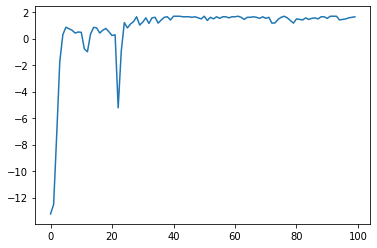

In [11]:
plt.plot(qt.total_reward)

In [12]:
def show_env(env, fname=None):
    plt.grid('on')
    n = env.map.shape[0]
    ax = plt.gca()
    ax.set_xticks(np.arange(0.5, n, 1))
    ax.set_yticks(np.arange(0.5, n, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    canvas = np.copy(env.map)
    for cell in env.visited:
        if env.visited[cell]:
            canvas[cell] = 0.9 #visited_mark
    for cell in env.books:
        canvas[cell] = 0.35 #book_mark
    canvas[env.target] = 0.55 #target_mark
    user,mode = env.state
    canvas[user] = 0.7 #robot_mark
    img = plt.imshow(canvas, interpolation='none', cmap='tab20b')
    if fname:
        plt.savefig(fname)
    return img

In [13]:
class Testing(object):
    def __init__(self, model, env, **opt):
        self.model = model
        self.env = env
        self.robot_cells = list(self.env.free_cells)
        self.weights_file = opt.get('weights_file', "")
        
        if self.weights_file:
            print("loading weights from file: %s" % (self.weights_file,))
            self.model.load_weights(self.weights_file)
        
    def run_game(self, robot):
        
        self.env.reset(robot)
        env_state = self.env.observe()
        
        show_env(self.env,str(robot)+".png")
        round = 0
        
        while True:
            q = self.model.predict(env_state)
            action = np.argmax(q[0])
            prev_env_state = env_state
            env_state, reward, game_status = self.env.step(action)
            
            round = round + 1
            show_env(self.env,str(robot)+str(round)+".png")
            
            print("current position : ",self.env.state," | action : ",action," | reward : ",reward," | game_status : ",game_status, self.env.total_reward)
            
            if game_status == 'win':
                return True
            elif game_status == 'lose':
                return False
    
    def completion_check(self):
        for robot in self.robot_cells:
            print("robot : ",robot)
            if not self.run_game(robot):
                return False
        return True



In [14]:
qtest = Testing(
    model,
    env
)

### have load weight
# qtest = Testing(
#     model,
#     env,
#     weights_file = 'model_leaky_dinamic.h5'    
# )

agent :  (4, 0)
current position :  ((3, 0), 'valid')  | action :  1  | reward :  0.3333333333333333  | game_status :  ongoing 0.3333333333333333
current position :  ((3, 1), 'valid')  | action :  2  | reward :  -0.04  | game_status :  ongoing 0.29333333333333333
current position :  ((2, 1), 'valid')  | action :  1  | reward :  -0.04  | game_status :  ongoing 0.25333333333333335
current position :  ((2, 2), 'valid')  | action :  2  | reward :  -0.04  | game_status :  ongoing 0.21333333333333335
current position :  ((1, 2), 'valid')  | action :  1  | reward :  -0.04  | game_status :  ongoing 0.17333333333333334
current position :  ((1, 3), 'valid')  | action :  2  | reward :  -0.04  | game_status :  ongoing 0.13333333333333333
current position :  ((0, 3), 'valid')  | action :  1  | reward :  0.3333333333333333  | game_status :  ongoing 0.4666666666666667
current position :  ((0, 4), 'valid')  | action :  2  | reward :  -0.04  | game_status :  ongoing 0.4266666666666667
current position 

current position :  ((2, 0), 'valid')  | action :  3  | reward :  -0.04  | game_status :  ongoing -0.04
current position :  ((3, 0), 'valid')  | action :  3  | reward :  0.3333333333333333  | game_status :  ongoing 0.29333333333333333
current position :  ((3, 1), 'valid')  | action :  2  | reward :  -0.04  | game_status :  ongoing 0.25333333333333335
current position :  ((2, 1), 'valid')  | action :  1  | reward :  -0.04  | game_status :  ongoing 0.21333333333333335
current position :  ((2, 2), 'valid')  | action :  2  | reward :  -0.04  | game_status :  ongoing 0.17333333333333334
current position :  ((1, 2), 'valid')  | action :  1  | reward :  -0.04  | game_status :  ongoing 0.13333333333333333
current position :  ((1, 3), 'valid')  | action :  2  | reward :  -0.04  | game_status :  ongoing 0.09333333333333332
current position :  ((0, 3), 'valid')  | action :  1  | reward :  0.3333333333333333  | game_status :  ongoing 0.42666666666666664
current position :  ((0, 4), 'valid')  | act

current position :  ((4, 4), 'valid')  | action :  3  | reward :  1.0  | game_status :  win 1.6
agent :  (2, 1)
current position :  ((3, 1), 'valid')  | action :  3  | reward :  -0.04  | game_status :  ongoing -0.04
current position :  ((3, 0), 'valid')  | action :  0  | reward :  0.3333333333333333  | game_status :  ongoing 0.29333333333333333
current position :  ((3, 1), 'valid')  | action :  2  | reward :  -0.04  | game_status :  ongoing 0.25333333333333335
current position :  ((2, 1), 'valid')  | action :  1  | reward :  -0.04  | game_status :  ongoing 0.21333333333333335
current position :  ((2, 2), 'valid')  | action :  2  | reward :  -0.04  | game_status :  ongoing 0.17333333333333334
current position :  ((1, 2), 'valid')  | action :  1  | reward :  -0.04  | game_status :  ongoing 0.13333333333333333
current position :  ((1, 3), 'valid')  | action :  2  | reward :  -0.04  | game_status :  ongoing 0.09333333333333332
current position :  ((0, 3), 'valid')  | action :  1  | reward 

current position :  ((2, 3), 'valid')  | action :  3  | reward :  -0.04  | game_status :  ongoing 0.21333333333333335
current position :  ((2, 2), 'valid')  | action :  0  | reward :  -0.04  | game_status :  ongoing 0.17333333333333334
current position :  ((2, 1), 'valid')  | action :  0  | reward :  -0.04  | game_status :  ongoing 0.13333333333333333
current position :  ((3, 1), 'valid')  | action :  3  | reward :  -0.04  | game_status :  ongoing 0.09333333333333332
current position :  ((3, 0), 'valid')  | action :  0  | reward :  0.3333333333333333  | game_status :  ongoing 0.42666666666666664
current position :  ((2, 0), 'valid')  | action :  1  | reward :  -0.04  | game_status :  ongoing 0.38666666666666666
current position :  ((2, 1), 'valid')  | action :  2  | reward :  -0.04  | game_status :  ongoing 0.3466666666666667
current position :  ((2, 2), 'valid')  | action :  2  | reward :  -0.04  | game_status :  ongoing 0.3066666666666667
current position :  ((2, 3), 'valid')  | acti

True

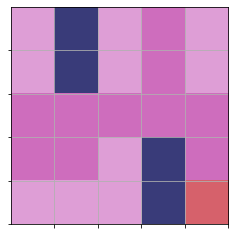

In [15]:
qtest.completion_check()